# Deploying my first ML model and prediction app!

### Prediction problem: Given a facial photo, predict the feeling in that.

Preface: After trying out Lesson 1 and 2 on a smaller set of emotions, I'm now attempting to do the following:
1. Create and train model across all 7 major emotions identified in the KDEF dataset (Ref:http://kdef.se/home/aboutKDEF.html).
2. Refine the model by altering LR and epochs till I get TL, VL and error rates in order.
3. Create simple web app to predict emotion when given image of human face.
4. Test the model against hand-picked set of Google images

First include essential instructions and libraries.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pdb

In [2]:
from fastai import *
from fastai.vision import *

Setting batch size to 64 for now. If you run out of memory, set to 16

In [3]:
bs=64

Prepare the directory structure and classes for creating and training the model and testing it as well.

In [4]:
#create primary path to save the model
path = Path('data/emotions')
#create classes list
emoclasses = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
#print stuff to verify
print(path)
print(emoclasses)

data/emotions
['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']


# KDEF Dataset for Training and Validation

## Download / Prepare dataset

In [5]:
#set training path
trainingpath = path/'kdef'
print(trainingpath)

data/emotions/kdef


Images are already downloaded into specific folders under the training path. Only need to verify them.

In [6]:
for i in range(len(emoclasses)):
    dest = trainingpath/emoclasses[i]
    print("Destination folder set to", dest)
    print("\nVerifying images now..")
    verify_images(dest, delete=True, max_workers=8)

Destination folder set to data/emotions/kdef/afraid

Verifying images now..


Destination folder set to data/emotions/kdef/angry

Verifying images now..


Destination folder set to data/emotions/kdef/disgusted

Verifying images now..


Destination folder set to data/emotions/kdef/happy

Verifying images now..


Destination folder set to data/emotions/kdef/neutral

Verifying images now..


Destination folder set to data/emotions/kdef/sad

Verifying images now..


Destination folder set to data/emotions/kdef/surprised

Verifying images now..


Creating image databunch on this dataset now...

In [27]:
np.random.seed(42)
data7emo = ImageDataBunch.from_folder(path, train="./kdef", valid_pct=0.2, 
                                      ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [28]:
data7emo.classes, data7emo.c, len(data7emo.train_ds), len(data7emo.valid_ds)

(['surprised', 'afraid', 'happy', 'angry', 'sad', 'disgusted', 'neutral'],
 7,
 3919,
 979)

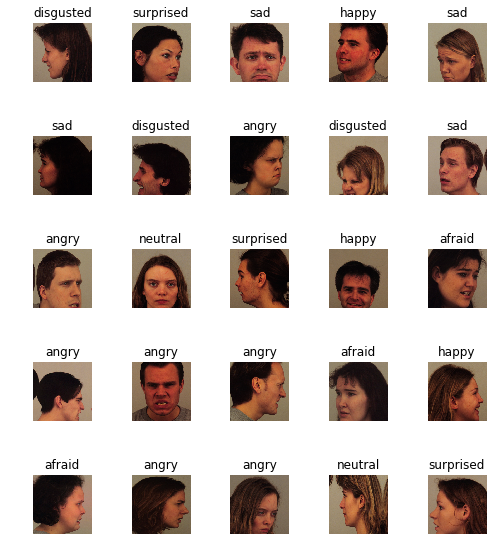

In [29]:
data7emo.show_batch(rows=5, figsize=(7,8))

## Train model on kdef dataset

In [30]:
learn7emo = create_cnn(data7emo, models.resnet34, metrics=error_rate)

In [33]:
learn7emo.fit_one_cycle(8)

Total time: 06:41
epoch  train_loss  valid_loss  error_rate
1      0.980848    2.072656    0.500511    (00:51)
2      0.718654    0.818129    0.300306    (00:50)
3      0.674460    0.912822    0.292135    (00:50)
4      0.604198    0.356835    0.113381    (00:50)
5      0.476914    0.410235    0.139939    (00:49)
6      0.381146    0.369050    0.119510    (00:50)
7      0.269206    0.204339    0.067416    (00:50)
8      0.197162    0.193219    0.064351    (00:49)



In [34]:
learn7emo.save('stage-7emo1')

First stage done and saved. Interesting that at 6% error the TL and VL are almost equal. Now let us try to improve it by adjusting learning rates.

In [35]:
learn7emo.unfreeze()
learn7emo.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


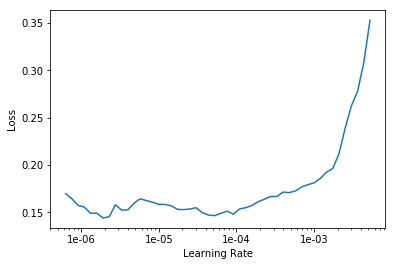

In [36]:
learn7emo.recorder.plot()

Logic for selecting LR range (1e-7,3e-6): pick the sharpest downward slope and find a LR slice to cover that.

In [37]:
learn7emo.fit_one_cycle(4, max_lr=slice(1e-7,3e-6))

Total time: 03:19
epoch  train_loss  valid_loss  error_rate
1      0.170686    0.194772    0.063330    (00:48)
2      0.156084    0.192507    0.063330    (00:49)
3      0.170141    0.189226    0.060266    (00:50)
4      0.170002    0.191452    0.059244    (00:51)



In [38]:
learn7emo.save('stage-7emo2')

Unfreeze and retrain with different epochs and learning rates. 
No need to do this if earlier stages yielded low error rates. Just save and load that stage later.

In [40]:
learn7emo.unfreeze()
learn7emo.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


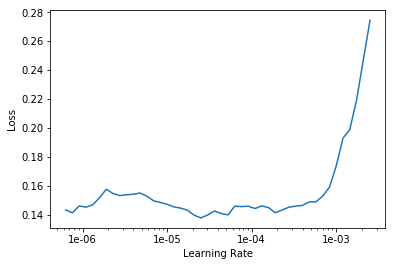

In [41]:
learn7emo.recorder.plot()

In [43]:
learn7emo.fit_one_cycle(8, max_lr=slice(7e-6,4e-5))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      0.150338    0.185255    0.058223    (00:50)
2      0.156777    0.187600    0.060266    (00:50)
3      0.145457    0.173250    0.055158    (00:48)
4      0.134028    0.171079    0.057201    (00:49)
5      0.137573    0.169403    0.060266    (00:49)
6      0.135531    0.169122    0.058223    (00:51)
7      0.137121    0.169476    0.058223    (00:50)
8      0.137654    0.167965    0.055158    (00:49)



In [44]:
learn7emo.save('stage-7emo3')

## Interpret results from KDEF dataset

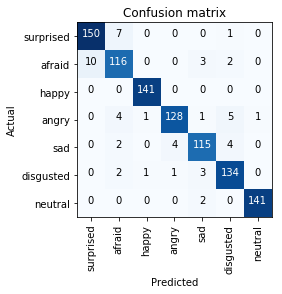

In [45]:
learn7emo.load('stage-7emo3')
interp = ClassificationInterpretation.from_learner(learn7emo)
interp.plot_confusion_matrix()

In [46]:
interp.most_confused(min_val=2)

[('afraid', 'surprised', 10),
 ('surprised', 'afraid', 7),
 ('angry', 'disgusted', 5),
 ('angry', 'afraid', 4),
 ('sad', 'angry', 4),
 ('sad', 'disgusted', 4),
 ('afraid', 'sad', 3),
 ('disgusted', 'sad', 3)]

So after stage 3, the model has a 5.5% error rate and is mostly confused between angry and surprised. And TL is less than VL as it should be. Let's view the images to see if its confusing to us too.

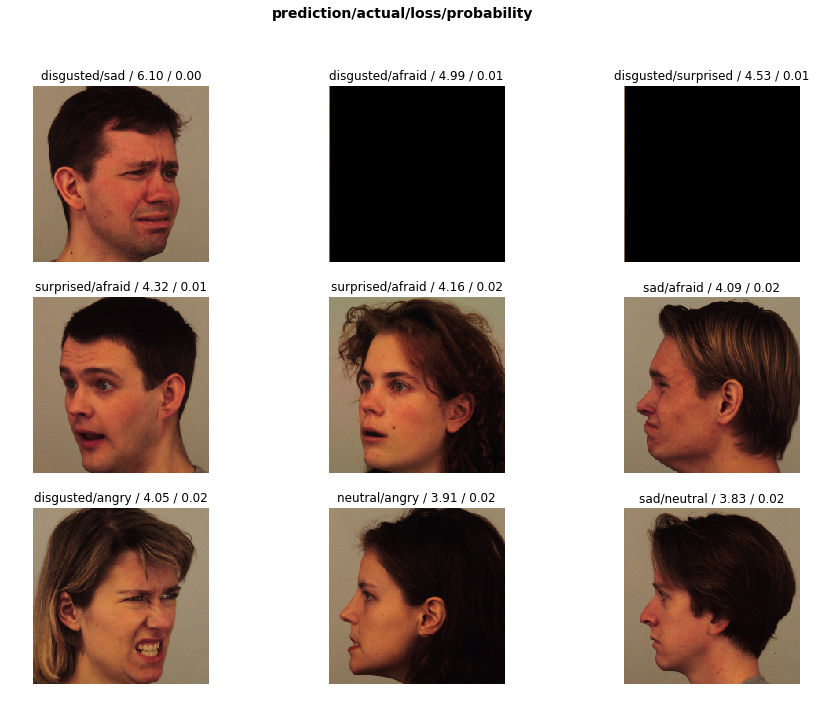

In [47]:
interp.plot_top_losses(9, figsize=(15,11))

Looks like we have some bad image files. Need to clean those up.

## Cleaning up the data (if required)

After training the model once we can identify the top losses and look the images that caused them. Then manually prune the data to improve the training accuracy using the FileDeleter widget. This is an example of how to use it.

In [56]:
from fastai.widgets import *
ds, idxs = DatasetFormatter().from_toplosses(learn7emo, ds_type=DatasetType.Valid)

In [59]:
#fd = ImageDeleter(ds, idxs)

The line above was executed and the bad image files cleaned up.

## Running more cycles with varying LR and epochs to further reduce error rate

Creating new data bunch because we deleted some files in the previous step and the old data bunch will still be pointing to them.

In [65]:
np.random.seed(42)
data7emo_clean = ImageDataBunch.from_folder(path, train="./kdef", valid_pct=0.2, 
                                      ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [66]:
data7emo_clean.classes, data7emo_clean.c, len(data7emo_clean.train_ds), len(data7emo_clean.valid_ds)

(['surprised', 'afraid', 'happy', 'angry', 'sad', 'disgusted', 'neutral'],
 7,
 3916,
 979)

In [67]:
learn7emo = create_cnn(data7emo_clean, models.resnet34, metrics=error_rate)

Load the last stage weights and then try training the model some more.

In [ ]:
learn7emo.load('stage-7emo3')
learn7emo.unfreeze()
learn7emo.lr_find()

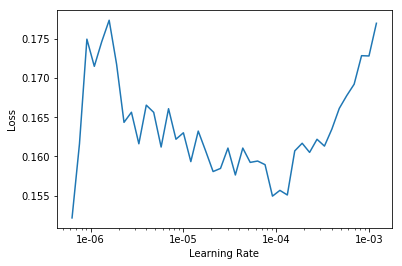

In [69]:
learn7emo.recorder.plot()

What in the world is this! Now I am totally lost!! The sharpest slope is starting around 2e-6 but the downward trend continues till 1e-4. So picking that as my range for LR.

In [70]:
learn7emo.fit_one_cycle(4, max_lr=slice(2e-6,1e-4))

Total time: 03:15
epoch  train_loss  valid_loss  error_rate
1      0.168769    0.072207    0.021450    (00:49)
2      0.158459    0.072737    0.025536    (00:49)
3      0.146233    0.077006    0.025536    (00:48)
4      0.135930    0.074030    0.023493    (00:49)



Yikes. My TL is now higher than my VL. But my error rate has come down to 2.3%. Is this good or bad? I think this means my model is underfitted and I need to increase the epochs and train some more. Let's save and try that..

In [71]:
learn7emo.save('stage-7emo4-postcleanup')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


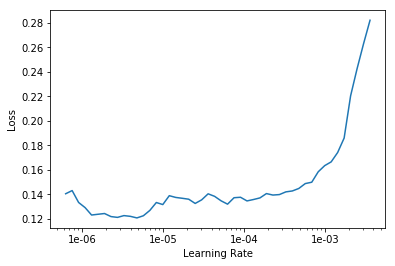

In [72]:
learn7emo.unfreeze()
learn7emo.lr_find()
learn7emo.recorder.plot()

In [74]:
learn7emo.fit_one_cycle(8, max_lr=slice(8e-7,6e-6))

Total time: 06:32
epoch  train_loss  valid_loss  error_rate
1      0.141243    0.076823    0.023493    (00:49)
2      0.139161    0.074119    0.023493    (00:48)
3      0.138985    0.071541    0.023493    (00:49)
4      0.126039    0.070685    0.025536    (00:48)
5      0.129188    0.078196    0.023493    (00:48)
6      0.121592    0.070078    0.021450    (00:48)
7      0.124718    0.068867    0.023493    (00:49)
8      0.131068    0.070851    0.021450    (00:49)



In [76]:
learn7emo.save('stage-7emo5-tlhigherthanvl-retrain')

OK, the training loss is still higher than validation loss (even though error rate is reducing) AND all rates are improving super slowly. So I will reset to stage 3 again and try a higher set of epochs and faster learning rates.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


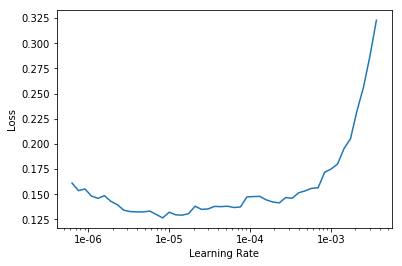

In [80]:
learn7emo.load('stage-7emo3')
learn7emo.unfreeze()
learn7emo.lr_find()
learn7emo.recorder.plot()

In [81]:
learn7emo.fit_one_cycle(20, max_lr=slice(1e-6,1e-4))

Total time: 16:33
epoch  train_loss  valid_loss  error_rate
1      0.161466    0.075851    0.024515    (00:50)
2      0.158738    0.076029    0.024515    (00:49)
3      0.150056    0.075914    0.025536    (00:49)
4      0.153033    0.078479    0.024515    (00:48)
5      0.155501    0.075100    0.021450    (00:48)
6      0.144915    0.077907    0.025536    (00:48)
7      0.145867    0.073102    0.026558    (00:49)
8      0.148044    0.076336    0.026558    (00:51)
9      0.171838    0.076622    0.028601    (00:48)
10     0.140451    0.069820    0.021450    (00:49)
11     0.124684    0.069405    0.020429    (00:49)
12     0.123992    0.067836    0.020429    (00:50)
13     0.121943    0.067496    0.020429    (00:49)
14     0.120769    0.071789    0.023493    (00:51)
15     0.125314    0.072739    0.025536    (00:49)
16     0.116523    0.071704    0.020429    (00:49)
17     0.108858    0.070713    0.025536    (00:49)
18     0.121818    0.070082    0.021450    (00:49)
19     0.116018    0.0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


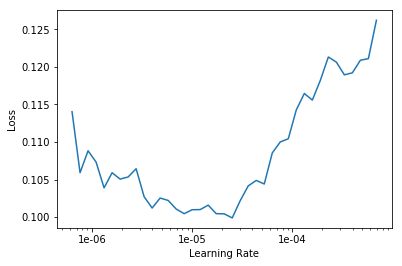

In [82]:
#TL still higher than VL so keep training
learn7emo.unfreeze()
learn7emo.lr_find()
learn7emo.recorder.plot()

In [83]:
learn7emo.fit_one_cycle(20, max_lr=slice(4e-6,4e-5))

Total time: 16:39
epoch  train_loss  valid_loss  error_rate
1      0.134862    0.072736    0.023493    (00:49)
2      0.128723    0.070448    0.020429    (00:51)
3      0.129246    0.068090    0.019408    (00:49)
4      0.121022    0.071958    0.021450    (00:51)
5      0.115184    0.070403    0.021450    (00:49)
6      0.109814    0.068585    0.020429    (00:50)
7      0.129151    0.071275    0.022472    (00:50)
8      0.122263    0.068364    0.023493    (00:49)
9      0.117019    0.071621    0.023493    (00:50)
10     0.104215    0.069790    0.023493    (00:49)
11     0.098864    0.069942    0.023493    (00:49)
12     0.102197    0.072350    0.021450    (00:48)
13     0.103038    0.070442    0.020429    (00:49)
14     0.101469    0.070717    0.021450    (00:49)
15     0.101881    0.067273    0.022472    (00:50)
16     0.100119    0.069468    0.021450    (00:50)
17     0.099904    0.069854    0.021450    (00:50)
18     0.103083    0.069702    0.022472    (00:49)
19     0.099200    0.0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


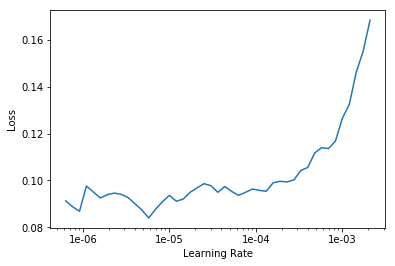

In [85]:
#TL still higher than VL so keep training
learn7emo.unfreeze()
learn7emo.lr_find()
learn7emo.recorder.plot()

In [86]:
#going to try something different... go back to a higher learning rate with larger epochs
learn7emo.fit_one_cycle(20, max_lr=slice(1e-6,1e-4))

Total time: 16:36
epoch  train_loss  valid_loss  error_rate
1      0.093255    0.068181    0.021450    (00:49)
2      0.099455    0.066268    0.020429    (00:50)
3      0.099939    0.066978    0.020429    (00:49)
4      0.092980    0.066762    0.020429    (00:49)
5      0.086540    0.068039    0.022472    (00:49)
6      0.086318    0.068302    0.021450    (00:49)
7      0.090373    0.066767    0.023493    (00:51)
8      0.090330    0.066601    0.021450    (00:51)
9      0.090494    0.069207    0.024515    (00:49)
10     0.092832    0.069326    0.023493    (00:48)
11     0.092829    0.065964    0.020429    (00:49)
12     0.084604    0.067488    0.020429    (00:49)
13     0.091609    0.065863    0.021450    (00:48)
14     0.100305    0.066662    0.019408    (00:50)
15     0.091159    0.067346    0.021450    (00:50)
16     0.081296    0.061730    0.019408    (00:49)
17     0.083259    0.067911    0.022472    (00:49)
18     0.086584    0.062421    0.022472    (00:49)
19     0.089588    0.0

OK. At this stage I've managed to get TL quite close to VL and a error rate of 1.9%. I am going to save this stage and use it for production now - because that's about how much training I can deal with for a day!

In [87]:
learn7emo.save('stage-7emo6-decenttlvler-goproduction')

# Train more with Kaggle FER set

I got the Kaggle FER datset as a download. Will create a new data bunch and train some more.

Citation: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

Thanks to Ilia (https://iliazaitsev.me/) for the script to convert from csv to images.

Setup images with folder names for categories, separately for train and valid sets.

In [5]:
kagglepath = Path('data/emotions/kagglefer')
kagglepath.ls()

[PosixPath('data/emotions/kagglefer/README'),
 PosixPath('data/emotions/kagglefer/fer.tar.gz'),
 PosixPath('data/emotions/kagglefer/fer2013.bib'),
 PosixPath('data/emotions/kagglefer/valid'),
 PosixPath('data/emotions/kagglefer/train'),
 PosixPath('data/emotions/kagglefer/models'),
 PosixPath('data/emotions/kagglefer/fer2013.tar.gz'),
 PosixPath('data/emotions/kagglefer/fer2013.csv'),
 PosixPath('data/emotions/kagglefer/.ipynb_checkpoints')]

Images are already downloaded intro train and valid folders. Verify images once before proceeding..

In [6]:
print(emoclasses)

['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']


In [9]:
for i in range(len(emoclasses)):
    dest = kagglepath/'train'/emoclasses[i]
    print("Destination folder set to", dest)
    print("\nVerifying images now..")
    verify_images(dest, delete=True, max_workers=8)

Destination folder set to data/emotions/kagglefer/train/afraid

Verifying images now..


/opt/anaconda3/lib/python3.6/site-packages/fastprogress/fastprogress.py:95: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Destination folder set to data/emotions/kagglefer/train/angry

Verifying images now..


Destination folder set to data/emotions/kagglefer/train/disgusted

Verifying images now..


Destination folder set to data/emotions/kagglefer/train/happy

Verifying images now..


Destination folder set to data/emotions/kagglefer/train/neutral

Verifying images now..


Destination folder set to data/emotions/kagglefer/train/sad

Verifying images now..


Destination folder set to data/emotions/kagglefer/train/surprised

Verifying images now..


Create imagedatabunch from the pandas dataframe.

In [10]:
for i in range(len(emoclasses)):
    dest = kagglepath/'valid'/emoclasses[i]
    print("Destination folder set to", dest)
    print("\nVerifying images now..")
    verify_images(dest, delete=True, max_workers=8)

Destination folder set to data/emotions/kagglefer/valid/afraid

Verifying images now..


Destination folder set to data/emotions/kagglefer/valid/angry

Verifying images now..


Destination folder set to data/emotions/kagglefer/valid/disgusted

Verifying images now..


Destination folder set to data/emotions/kagglefer/valid/happy

Verifying images now..


Destination folder set to data/emotions/kagglefer/valid/neutral

Verifying images now..


Destination folder set to data/emotions/kagglefer/valid/sad

Verifying images now..


Destination folder set to data/emotions/kagglefer/valid/surprised

Verifying images now..


Now create the databunch from folders

In [7]:
np.random.seed(42)
kaggledata = ImageDataBunch.from_folder(kagglepath, train='train', valid='valid', 
                                        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [8]:
kaggledata.classes, kaggledata.c, len(kaggledata.train_ds), len(kaggledata.valid_ds)

(['happy', 'angry', 'surprise', 'fear', 'sad', 'disgust', 'neutral'],
 7,
 32298,
 3589)

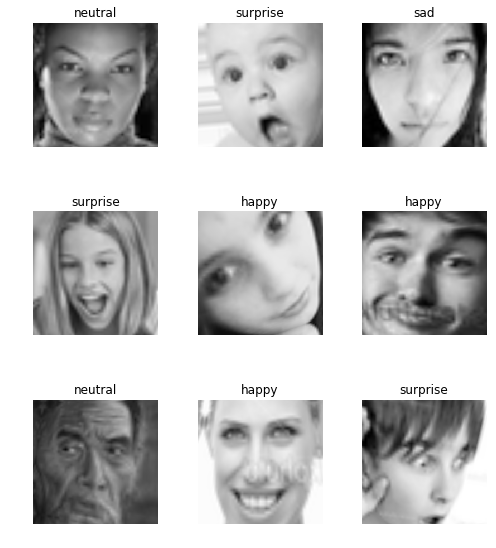

In [9]:
kaggledata.show_batch(rows=3, figsize=(7,8))

### Data is setup, now on to loading saved model and training it some more.

In [10]:
learn = create_cnn(kaggledata, models.resnet34, metrics=[accuracy, error_rate])

In [33]:
learn.load('stage-7emo6-decenttlvler-goproduction')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (32298 items)
['happy' 'happy' 'happy' 'happy' ... 'neutral' 'neutral' 'neutral' 'neutral']
Path: .
x: ImageItemList (32298 items)
[PosixPath('data/emotions/kagglefer/train/happy/f28170.png') PosixPath('data/emotions/kagglefer/train/happy/f3338.png')
 PosixPath('data/emotions/kagglefer/train/happy/f7171.png') PosixPath('data/emotions/kagglefer/train/happy/f7585.png')
 ... PosixPath('data/emotions/kagglefer/train/neutral/f2019.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f27331.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f10533.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f21785.png')]
Path: data/emotions/kagglefer;
Valid: LabelList
y: CategoryList (3589 items)
['happy' 'happy' 'happy' 'happy' ... 'neutral' 'neutral' 'neutral' 'neutral']
Path: .
x: ImageItemList (3589 items)
[PosixPath('data/emotions/kagglefer/valid/happy/f35521.png')
 PosixPath('data/emotions/kagglefer/valid/happy/f33653.png

In [24]:
learn.fit_one_cycle(8)

Total time: 26:28
epoch  train_loss  valid_loss  error_rate
1      1.176402    1.129642    0.424631    (03:18)
2      1.160319    1.154552    0.446643    (03:18)
3      1.101520    1.080946    0.407356    (03:18)
4      1.010239    1.018760    0.396489    (03:18)
5      0.917587    0.906515    0.339092    (03:18)
6      0.843512    0.836548    0.310114    (03:18)
7      0.769122    0.797729    0.295068    (03:18)
8      0.717815    0.797347    0.291446    (03:18)



In [25]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


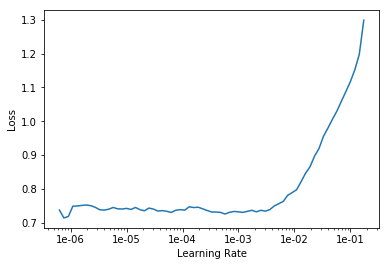

In [26]:
learn.recorder.plot()

In [27]:
learn.save('kagglestage-7emo6production-round1')

In [15]:
learn.load('kagglestage-7emo6production-round1')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (32298 items)
['happy' 'happy' 'happy' 'happy' ... 'neutral' 'neutral' 'neutral' 'neutral']
Path: .
x: ImageItemList (32298 items)
[PosixPath('data/emotions/kagglefer/train/happy/f28170.png') PosixPath('data/emotions/kagglefer/train/happy/f3338.png')
 PosixPath('data/emotions/kagglefer/train/happy/f7171.png') PosixPath('data/emotions/kagglefer/train/happy/f7585.png')
 ... PosixPath('data/emotions/kagglefer/train/neutral/f2019.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f27331.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f10533.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f21785.png')]
Path: data/emotions/kagglefer;
Valid: LabelList
y: CategoryList (3589 items)
['happy' 'happy' 'happy' 'happy' ... 'neutral' 'neutral' 'neutral' 'neutral']
Path: .
x: ImageItemList (3589 items)
[PosixPath('data/emotions/kagglefer/valid/happy/f35521.png')
 PosixPath('data/emotions/kagglefer/valid/happy/f33653.png

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


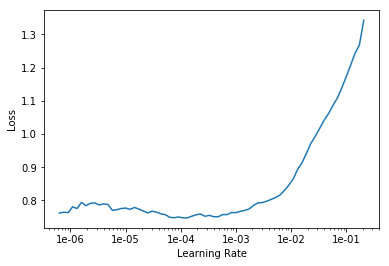

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-4))

Total time: 1:05:37
epoch  train_loss  valid_loss  error_rate
1      0.734973    0.796759    0.294790    (03:14)
2      0.730800    0.796651    0.294232    (03:16)
3      0.719358    0.795178    0.292003    (03:16)
4      0.745408    0.797764    0.294790    (03:16)
5      0.717469    0.794198    0.293954    (03:16)
6      0.700142    0.794196    0.294790    (03:16)
7      0.732817    0.794856    0.294511    (03:17)
8      0.698897    0.794566    0.292003    (03:16)
9      0.695929    0.795464    0.297855    (03:16)
10     0.723669    0.793665    0.292282    (03:17)
11     0.719485    0.794805    0.294790    (03:17)
12     0.715213    0.792380    0.292561    (03:16)
13     0.724132    0.792805    0.293396    (03:17)
14     0.699398    0.792841    0.294232    (03:17)
15     0.677411    0.790948    0.294511    (03:17)
16     0.702932    0.792526    0.293118    (03:16)
17     0.710686    0.793010    0.294232    (03:17)
18     0.702447    0.792526    0.295347    (03:17)
19     0.700505    0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


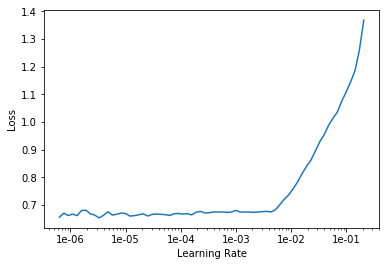

In [18]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,5e-3))

Total time: 32:46
epoch  train_loss  valid_loss  error_rate
1      0.702988    0.803283    0.293118    (03:13)
2      0.723808    0.803765    0.298133    (03:16)
3      0.736266    0.803370    0.294232    (03:17)
4      0.737162    0.807945    0.302313    (03:17)
5      0.734344    0.794276    0.287267    (03:16)
6      0.684963    0.798386    0.291167    (03:16)
7      0.687930    0.793161    0.288381    (03:16)
8      0.647780    0.798131    0.285316    (03:16)
9      0.638311    0.794200    0.289217    (03:17)
10     0.628462    0.799510    0.290610    (03:17)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


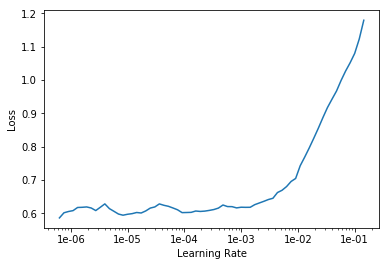

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.save('kagglestage-7emo6production-round2')

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

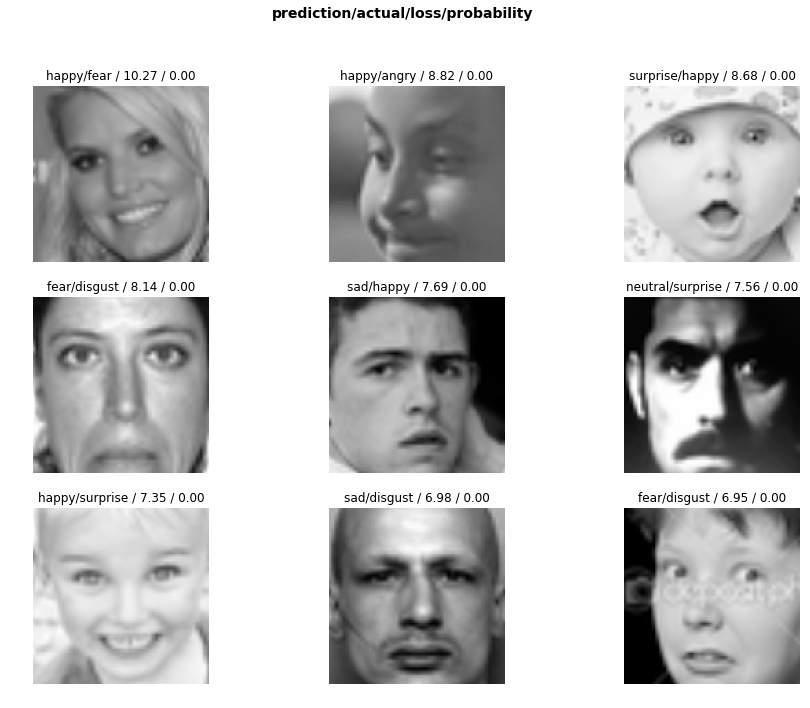

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

In [26]:
interp.most_confused(min_val=2)

[('fear', 'sad', 106),
 ('sad', 'neutral', 93),
 ('neutral', 'sad', 79),
 ('fear', 'angry', 75),
 ('angry', 'sad', 72),
 ('sad', 'fear', 68),
 ('fear', 'neutral', 55),
 ('sad', 'angry', 48),
 ('angry', 'fear', 45),
 ('fear', 'surprise', 45),
 ('happy', 'neutral', 38),
 ('surprise', 'fear', 38),
 ('angry', 'neutral', 33),
 ('neutral', 'angry', 28),
 ('surprise', 'happy', 22),
 ('neutral', 'happy', 21),
 ('neutral', 'fear', 20),
 ('sad', 'happy', 18),
 ('happy', 'surprise', 17),
 ('disgust', 'angry', 14),
 ('happy', 'angry', 13),
 ('happy', 'sad', 13),
 ('happy', 'fear', 11),
 ('angry', 'happy', 10),
 ('fear', 'happy', 10),
 ('surprise', 'angry', 8),
 ('surprise', 'neutral', 7),
 ('neutral', 'surprise', 7),
 ('angry', 'surprise', 6),
 ('angry', 'disgust', 6),
 ('surprise', 'sad', 4),
 ('sad', 'surprise', 3),
 ('sad', 'disgust', 3)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


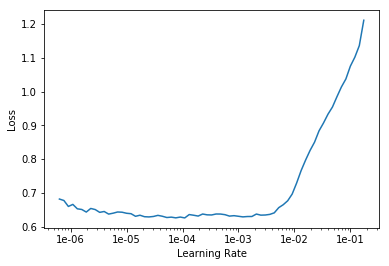

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.load('kagglestage-7emo6production-round2')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (32298 items)
['happy' 'happy' 'happy' 'happy' ... 'neutral' 'neutral' 'neutral' 'neutral']
Path: .
x: ImageItemList (32298 items)
[PosixPath('data/emotions/kagglefer/train/happy/f28170.png') PosixPath('data/emotions/kagglefer/train/happy/f3338.png')
 PosixPath('data/emotions/kagglefer/train/happy/f7171.png') PosixPath('data/emotions/kagglefer/train/happy/f7585.png')
 ... PosixPath('data/emotions/kagglefer/train/neutral/f2019.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f27331.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f10533.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f21785.png')]
Path: data/emotions/kagglefer;
Valid: LabelList
y: CategoryList (3589 items)
['happy' 'happy' 'happy' 'happy' ... 'neutral' 'neutral' 'neutral' 'neutral']
Path: .
x: ImageItemList (3589 items)
[PosixPath('data/emotions/kagglefer/valid/happy/f35521.png')
 PosixPath('data/emotions/kagglefer/valid/happy/f33653.png

In [29]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,5e-3), wd=1e-1)

Total time: 32:46
epoch  train_loss  valid_loss  error_rate
1      0.643452    0.802904    0.290053    (03:13)
2      0.672704    0.792223    0.286152    (03:16)
3      0.662260    0.797821    0.290053    (03:17)
4      0.678527    0.814841    0.293118    (03:17)
5      0.630654    0.837558    0.298133    (03:17)
6      0.628013    0.823211    0.292561    (03:16)
7      0.606977    0.815470    0.288938    (03:17)
8      0.614938    0.802680    0.284202    (03:17)
9      0.589065    0.818236    0.285038    (03:17)
10     0.573561    0.813494    0.286431    (03:17)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


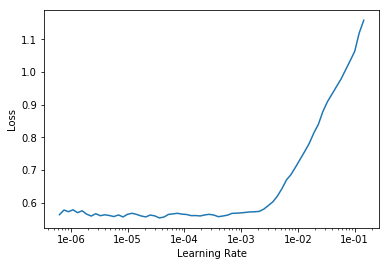

In [30]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, 5e-5, moms=(0.8,0.7), wd=1e-1, pct_start=0.5)

Total time: 32:44
epoch  train_loss  valid_loss  error_rate
1      0.552202    0.819024    0.289217    (03:13)
2      0.560601    0.816153    0.284480    (03:16)
3      0.570717    0.811261    0.285595    (03:16)
4      0.554114    0.819952    0.283923    (03:17)
5      0.562622    0.812220    0.286431    (03:17)
6      0.566004    0.818510    0.290332    (03:16)
7      0.538813    0.824457    0.282251    (03:16)
8      0.533063    0.830773    0.283923    (03:16)
9      0.498240    0.832565    0.289217    (03:16)
10     0.504502    0.836960    0.288381    (03:16)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


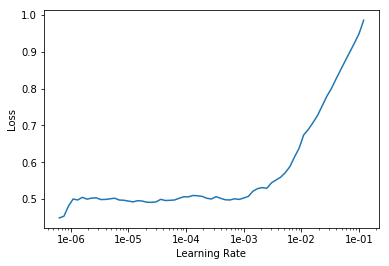

In [32]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(10, 5e-7, moms=(0.8,0.7), wd=1e-1, pct_start=0.5)

Total time: 32:45
epoch  train_loss  valid_loss  error_rate
1      0.490649    0.835839    0.286431    (03:14)
2      0.481775    0.833907    0.287545    (03:16)
3      0.476848    0.834719    0.287824    (03:16)
4      0.515749    0.835119    0.288660    (03:16)
5      0.474875    0.832804    0.286988    (03:16)
6      0.495950    0.827802    0.286709    (03:16)
7      0.507727    0.835779    0.288381    (03:16)
8      0.469237    0.836376    0.288103    (03:16)
9      0.493875    0.833055    0.284480    (03:17)
10     0.507523    0.834460    0.286709    (03:17)



In [40]:
learn.save('kagglestage-7emo6production-round3')

In [11]:
learn.load('kagglestage-7emo6production-round3')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (32298 items)
['happy' 'happy' 'happy' 'happy' ... 'neutral' 'neutral' 'neutral' 'neutral']
Path: .
x: ImageItemList (32298 items)
[PosixPath('data/emotions/kagglefer/train/happy/f28170.png') PosixPath('data/emotions/kagglefer/train/happy/f3338.png')
 PosixPath('data/emotions/kagglefer/train/happy/f7171.png') PosixPath('data/emotions/kagglefer/train/happy/f7585.png')
 ... PosixPath('data/emotions/kagglefer/train/neutral/f2019.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f27331.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f10533.png')
 PosixPath('data/emotions/kagglefer/train/neutral/f21785.png')]
Path: data/emotions/kagglefer;
Valid: LabelList
y: CategoryList (3589 items)
['happy' 'happy' 'happy' 'happy' ... 'neutral' 'neutral' 'neutral' 'neutral']
Path: .
x: ImageItemList (3589 items)
[PosixPath('data/emotions/kagglefer/valid/happy/f35521.png')
 PosixPath('data/emotions/kagglefer/valid/happy/f33653.png

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


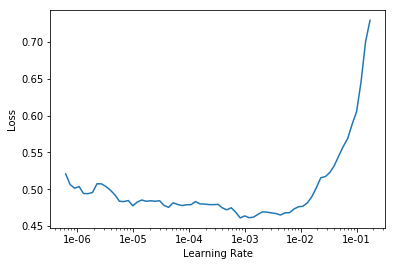

In [12]:
learn.lr_find()
learn.recorder.plot()

In [14]:
lr = 0.01
learn.fit_one_cycle(10, slice(lr))

Total time: 25:23
epoch  train_loss  valid_loss  accuracy  error_rate
1      0.524278    0.888240    0.708275  0.291725    (02:28)
2      0.600279    0.928294    0.693508  0.306492    (02:28)
3      0.628720    0.945142    0.685149  0.314851    (02:28)
4      0.633696    0.897745    0.693229  0.306771    (02:33)
5      0.634692    0.903420    0.696573  0.303427    (02:35)
6      0.599489    0.902158    0.697130  0.302870    (02:35)
7      0.575625    0.970642    0.706604  0.293397    (02:31)
8      0.515901    0.876662    0.714962  0.285038    (02:35)
9      0.533930    0.849360    0.712176  0.287824    (02:30)
10     0.494694    0.856736    0.711897  0.288103    (02:36)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


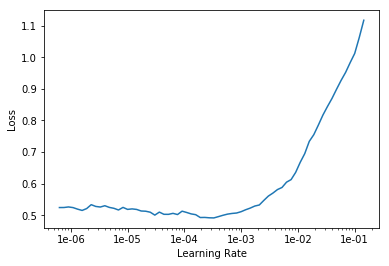

In [15]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10, slice(1e-5, lr/10), wd=1e-1)

Total time: 35:22
epoch  train_loss  valid_loss  accuracy  error_rate
1      0.504693    0.862031    0.712455  0.287545    (03:23)
2      0.489210    0.862275    0.715798  0.284202    (03:36)
3      0.514333    0.861803    0.709947  0.290053    (03:35)
4      0.519845    0.853612    0.704096  0.295904    (03:32)
5      0.487258    0.860368    0.717749  0.282251    (03:32)
6      0.452572    0.866841    0.723600  0.276400    (03:33)
7      0.421909    0.892458    0.718863  0.281137    (03:28)
8      0.407947    0.897214    0.714127  0.285873    (03:32)
9      0.393686    0.911912    0.714405  0.285595    (03:33)
10     0.373225    0.914340    0.714405  0.285595    (03:33)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


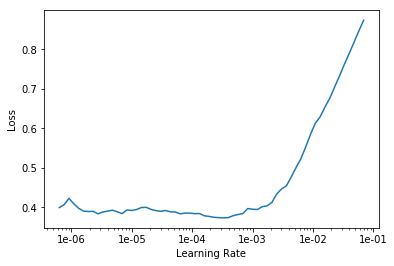

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

   # Putting model in production

To put this into production using zeit I first downloaded the model to a google drive. Then followed instructions from https://course-v3.fast.ai/deployment_zeit.html to setup zeit and create the app.

I created the download link using their utility. My download link is - https://drive.google.com/uc?export=download&id=1JXKVd1yqKNG_Nrwf4vpAAM-q0WJfkMH9.

Then I updated the server.py file with this link and also the classes. And made few simple changes to the html and css files and tested out my site! Here is the link, give it a go: https://fastai-howdoyoufeel.now.sh/

In [92]:
#make sure your server.py has the same order as in the ImageDataBunch (not the order you defined in classes)
print(emoclasses)
print(data7emo.classes)
print(data7emo_clean.classes)
# so in this case, the LAST sequence is what goes into server.py

# I spent an hour figuring this out - after all of my test images were predicted incorrectly!

['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
['surprised', 'afraid', 'happy', 'angry', 'sad', 'disgusted', 'neutral']
['surprised', 'afraid', 'happy', 'angry', 'sad', 'disgusted', 'neutral']


# Testing the model via the app - Some results and observations

I observed that the KDEF dataset uses males and females in age group 20-30 and the images suggested that they were predominantly caucasian. So I wanted to test my model against images of older women, people of color, kids/babies etc. Some results below:

HAPPY TEST CASE: Old tribal woman classified incorrectly -

<img src="images/Happy-YoungVsOld.png">

Possibly because of the wrinkles?

SAD TEST CASE: Crying kid classified incorrectly -

<img src="images/Sad-Kids-FaceVsCry.png">

In general, I'm finding crying faces being classified incorrectly as disgusted or afraid. Not as sad. Sad face frown is correctly identified as sad.

ANGRY TEST CASE: Both identified correctly! Angry woman is an angry woman, everywhere!! :D

<img src="images/Angry-YoungVsOld.png">


HAPPY BABY TEST CASE: asian baby incorrectly classified.

<img src="images/Happy-Babies.png">

I wonder if the middle image got classifed as 'Afraid' because the eyes are almost closed as they are likely to be when you make an "i'm afraid" expression.

## Conclusion

My goals with this project were to 
1) experience first hand how to train a CNN, 
2) how to improve the model and 
3) how to recognise bias in the training set and stress test for it. 

After the tests I am concluding that the model needs to be trained more... but I'm not sure if it should be trained more on the same KDEF dataset or perhaps some other FER dataset. I suppose the latter.

I also think it is possible to draw insights into how the model will react by closing observing the training dataset and the test data and the specific failures - I tried to comment along these lines above.

Ofcourse, I have more questions unanswered now than I had at the start... listing some of them below.

## Questions


Q1) Why import fastai.vision separately, doesn't fastai import * lead to importing all libraries under fastai?

Q2) If I have X images in my dataset. I get 20% X in validation set which makes sense (pct is 20%). But why do I have only lesser than 80% in the training set? Is that because the others could not be read/downloaded? Does that mean that ImageDataBunch will always ensure the validation set is selected to pct values and all image errors will only impact the training set?

Q3) After clean up of the data my training loss starts off being much higher than the validation loss. Why?

Q4) Looking at TL, VL and error rates, as I change LR and epochs - Can someone tell me what LR and epochs they would have selected and why so I know where I went wrong - as in why I needed so many cycles to get my TL lower than VL?

Q5) If we keep on iterating as above and training over and over, will that lead to overfitting? Even before TL becomes lower than VL?

Q6) After every unfreeze, when I retrain, why does training loss start higher than the lowest value in the previous cycle? Is that because I picked an incorrect range for the learning rate?

Q7) When TL, VL and error rates are all fluctuating but not showing any clear trends of up/down - can we conclude we need to train more?

Q8) Why did the sequence of classes change from the emoclasses order when the DataBunch was created?

Q9) At stage-7emo2 the TL is actually less than VL, but error rate is 5.9%. Should I have stopped here or keep trying to lower error rate?